Complexity Inference, Part I. Producing a pairwise distance matrix
---

Steps:
1. Produce gene-specific `.bed`, if it doesn't exist
2. Produce sample-gene-speciifc `.sam`, if it doesn't exist
3. Build a `gene_array` matrix
    - Save.
4. Filter to a `gene_informative` matrix given a `min_frequency`
5. Compute pairwise distance matrix
    - Save.
6. Perhaps some basic exploratory visualization

In [128]:
import os
import sys
import configparser
import getopt
import numpy as np
import pandas as pd
from collections import Counter

from lib.mutation import *
from lib.error import *
from lib.coi import *

In [129]:
from matplotlib import lines
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = [4, 4]

## 0 Settings

In [130]:
expt_dir = "../analysis/ont/zambia/2019-04-17"  # experiment of interest
gene_ini = "../data/resources/pf-regions/msp2.ini"
focus_sample = "BC04"

In [131]:
results_dir = expt_dir.replace("analysis", "results")
bam_path = os.path.join(results_dir, "%s.sorted.bam" % focus_sample)
assert os.path.isfile(bam_path), ".bam file does not exist."

In [132]:
config = configparser.ConfigParser()
config.read(gene_ini)

# hold gene location information
gene_dt = {}
gene_dt["name"] = config.get("Parameters", "name")
gene_dt["id"] = config.get("Parameters", "id")
gene_dt["genome"] = config.get("Parameters", "genome")
gene_dt["gff"] = config.get("Parameters", "gff")

If `save_figs` is set to `True`, then figures are automatically saved as `.png` under `../figs`, as well as visualized in the notebook.

In [133]:
save_figs = True
fig_dir = expt_dir.replace("analysis", "figs")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [134]:
save_intermediates = True
intermediate_dir = os.path.join(expt_dir, "coi")
if not os.path.exists(intermediate_dir):
    os.makedirs(intermediate_dir)

In [135]:
print("Save intermedaites:", save_intermediates)
print("Intermediate path:", intermediate_dir)

Save intermedaites: True
Intermediate path: ../analysis/ont/zambia/2019-04-17/coi


## 1  Produce a gene-specific `.bed`

Only if it does not already exist.

In [136]:
gene_ini_path = os.path.dirname(gene_ini)
exon_gff = "%s.exons.gff" % os.path.join(gene_ini_path, gene_dt["name"])
exon_bed = "%s.exons.bed" % os.path.join(gene_ini_path, gene_dt["name"])

In [137]:
if not os.path.isfile(exon_gff) or not os.path.isfile(exon_bed):
    print("Creating .gff and .bed file for %s" % gene_dt["name"])
    # Create a GFF describing the exons of the target gene
    cmd = "grep -E 'exon.*%s' %s > %s" % (gene_dt["id"],
                                          gene_dt["gff"],
                                          exon_gff)
    os.system(cmd)
    exon_df = pd.read_csv(exon_gff, sep="\t", header=-1)
    gff_columns = ["seq", "source", "feature", 
                   "start", "end", "score", "strand", 
                   "phase", "attributes"]
    exon_df.columns = gff_columns
    exon_df.start = exon_df.start - 1  # Off by one incongruity with mpileup, unfortunately.
    exon_df.to_csv(exon_gff, sep="\t", index=False, header=False)

    # Create an associated BED file
    cmd = "cut -f 1,4,5 %s > %s" % (exon_gff, exon_bed)
    os.system(cmd)
else:
    print(".gff and .bed file for %s already exist." % gene_dt["name"])
    exon_df = pd.read_csv(exon_gff, sep="\t", header=-1)
    gff_columns = ["seq", "source", "feature", 
                   "start", "end", "score", "strand", 
                   "phase", "attributes"]
    exon_df.columns = gff_columns

.gff and .bed file for MSP2 already exist.


## 2 Produce a sample-gene-specific `.sam`

In [138]:
output_path = os.path.join(intermediate_dir, "%s.%s.sam" % (focus_sample, gene_dt["name"]))
print("Output path for .sam:", output_path)

Output path for .sam: ../analysis/ont/zambia/2019-04-17/coi/BC04.MSP2.sam


In [139]:
if not os.path.isfile(output_path):
    cmd = "samtools view %s -L %s > %s" % (bam_path,
                                           exon_bed,
                                           output_path)
    print("Generating a .sam file containing %s overlapping reads ONLY." % gene_dt["name"])
    print("  Command:", cmd)
    os.system(cmd)
else:
    print(".sam file already exists.")

.sam file already exists.


## 3 Build a `gene_array` matrix

In [140]:
verbose = False

In [141]:
with open(output_path, "r+") as sam:
    gene_start = exon_df.start[0]
    gene_end = exon_df.end[0]
    gene_length = gene_end - gene_start
    
    if verbose:
        print("Gene start:", gene_start)
        print("Gene end:", gene_end)
        print("Gene length:", gene_length)
    
    gene_ints = []
    flags = []
    for line in sam:
        _, flag, _, start, _, cigar, _, _, _, seq = line.split()[:10]
                
        if verbose:
            print("Start:", start)
            print("CIGAR:", cigar[:10], " ...")
            print("Sequence:", seq[:10], " ...")
        
        
        # Process the CIGAR string of each read,
        # assigning reference position to each base
        start = int(start)
        positions, mapped_seq = process_by_cigar(start, seq, cigar)
        
        # Filter for bases within coding region
        gene_bases = [c 
                      for c, p in zip(mapped_seq, positions) 
                      if gene_start < p <= gene_end]
        
        
        # Reverse complement if necessary
        if exon_df["strand"][0] == '-':
            gene_bases = [complement_map[c] for c in gene_bases[::-1]]
        
        # If the read spanned the entire coding region, save
        if len(gene_bases) == gene_length:
            gene_ints.append(np.array([dna_to_ints[c] for c in gene_bases]))
            flags.append(flag)

In [142]:
gene_array = np.vstack(gene_ints)

In [143]:
f = open(output_path, "r+")
print("Total number of alignments:", len(f.readlines()))
print("")
print("Gene Array Dimensions:")
print("Alignments spanning entire coding sequence (rows):", gene_array.shape[0])
print("Sites (columns):", gene_array.shape[0])

Total number of alignments: 8620

Gene Array Dimensions:
Alignments spanning entire coding sequence (rows): 7398
Sites (columns): 7398


In [144]:
if save_intermediates:
    np.save(os.path.join(intermediate_dir, "%s.%s.gene_array.npy" % (focus_sample, gene_dt["name"])),
            gene_array)

## 4 Filter to informative sites creating `gene_informative`

Note that I filter on the entire stack of reads, despite downsampling for the pairwise-distance matrix.

In [145]:
gene_informative = filter_to_informative_sites(gene_array, min_frequency=0.05, verbose=True)

Number of reads: 7398
Number of sites: 819
Frequency min.: 0.05
Count min.: 369
Ignore indels?: True
Number of informative sites: 351


## 5 Downsample to reduce computational time

In [146]:
n_keep = 250
n_reads, n_informative_sites = gene_informative.shape
ixs = np.random.choice(n_reads, n_keep, replace=False)

In [147]:
gene_informative = gene_informative[ixs, :]

In [148]:
print("Pre-/post- downsampling")
print("reads (pre-downsample):", n_reads)
print("sites (pre-downsample):", n_informative_sites)
print("reads (post-downsample):", gene_informative.shape[0])

Pre-/post- downsampling
reads (pre-downsample): 7398
sites (pre-downsample): 351
reads (post-downsample): 250


## 6 Calculate pairwise distance matrix

In [149]:
distance_matrix = calc_distance_matrix(gene_informative, ignore_indels=True, metric='jaccard')

In [150]:
X_square = distance.squareform(distance_matrix)

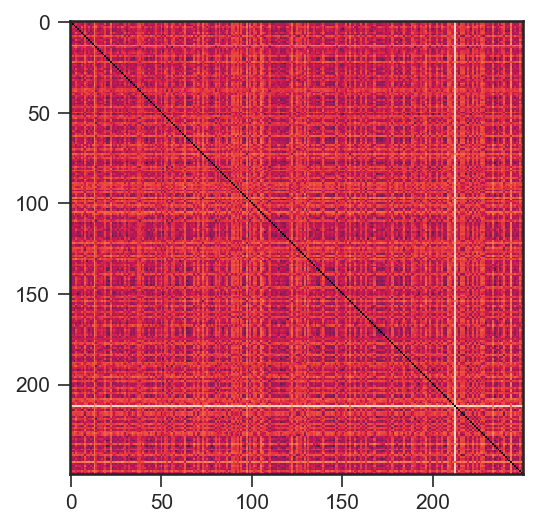

In [151]:
plt.imshow(X_square)

## 7 Play around with clustering

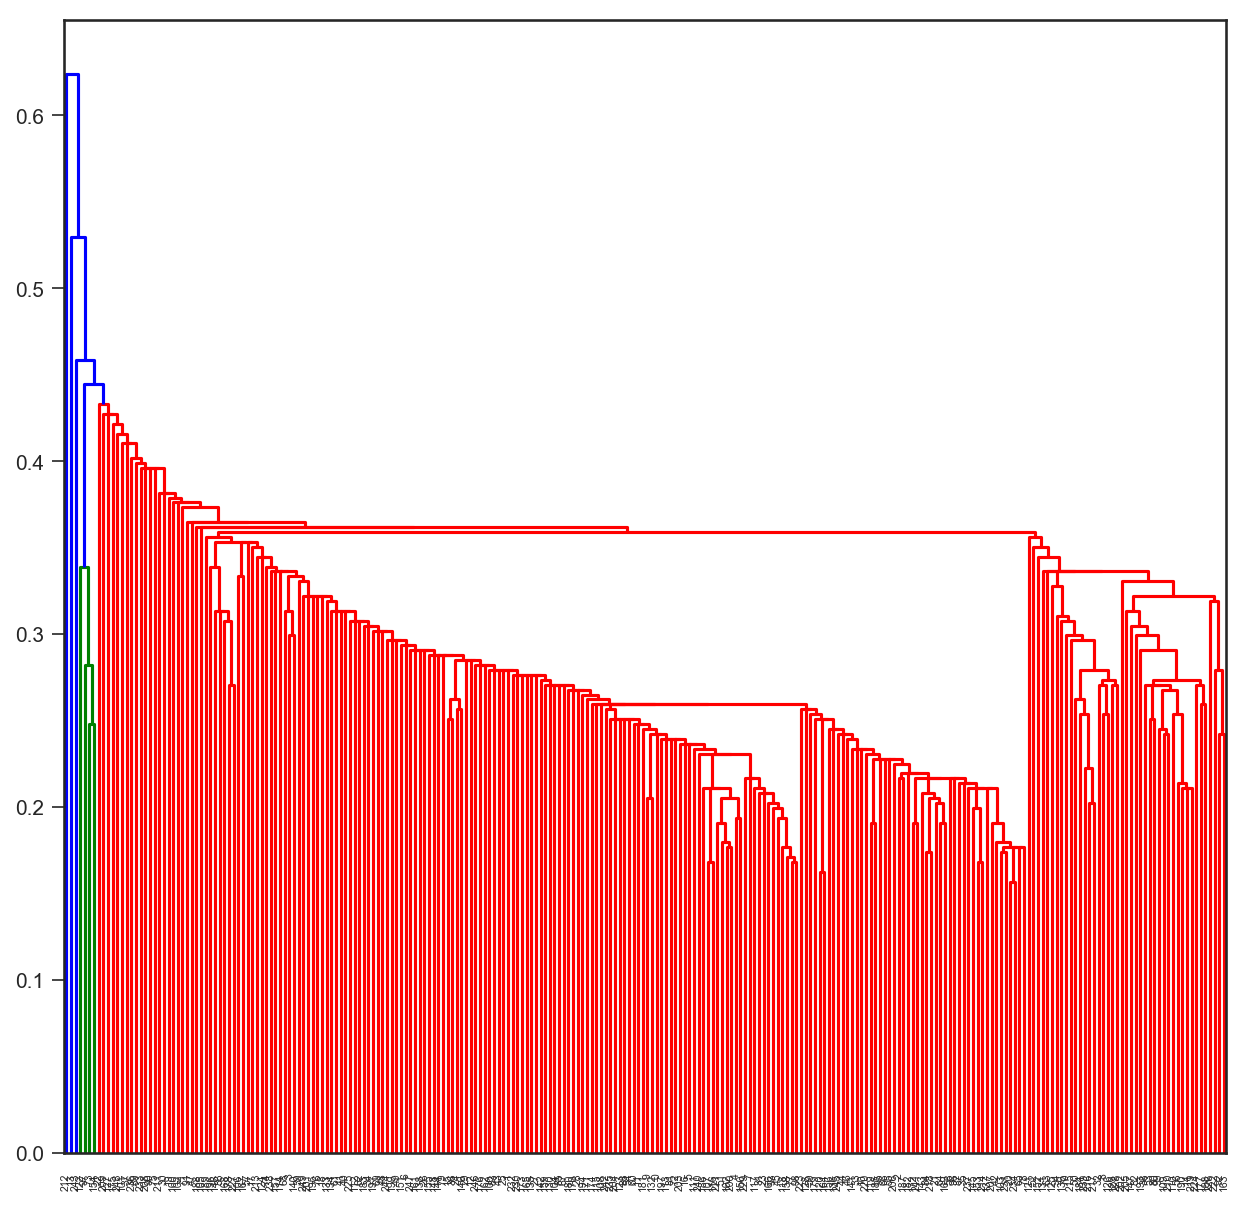

In [152]:
fig = plt.figure(figsize=(10, 10))

Z = linkage(distance_matrix)
dn = dendrogram(Z)
plt.show()

In [153]:
X1 = X_square[dn["leaves"]]
X2 = X1[:, dn["leaves"]]

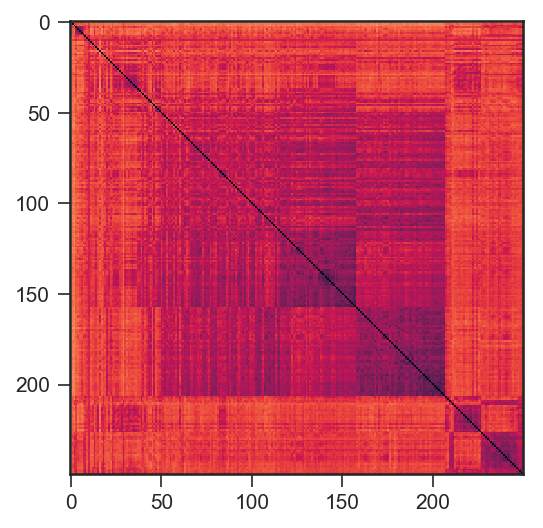

In [154]:
plt.imshow(X2)

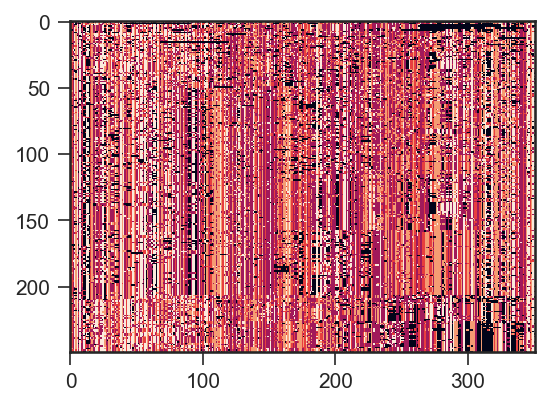

In [155]:
plt.imshow(gene_informative[dn["leaves"]])